## Experiment 2
<br>
-- ViT Base model hyperparameters explore


In [1]:
import json
import re
import random
import os
from collections import defaultdict
from itertools import product

import tensorflow as tf
import pandas as pd
import numpy as np

import utils

2023-01-05 13:32:50.184763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 13:32:50.742765: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-01-05 13:32:50.742808: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-01-05 13:32:50.742813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] 

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything()

### Data Load

In [3]:
data_path = '/home/donghyun/eye_writing_classification/v2_dataset/200_points_dataset/'

with open(data_path + 'eog_raw_numbers_200.json') as f:
  eog_raw_numbers = json.load(f)

with open(data_path + 'reference_data_200.json') as f:
  reference_data = json.load(f)

### Experiment

In [4]:
# hyperparameters

vit_hidden_size = [128,256,512]
vit_patch_size = [5,10]
vit_heads = [4,8]
vit_n_layers = [8,12]
vit_mlp_units = [[128,64],
                 [64,32]]
vit_dropout = [0]
vit_mlp_dropout = [0]

In [5]:
# Config class

class Config:
    split_ratio = 0.3
    ref_key = 'numbers'
    batch_size = 10            # fix : must be equaled with number of test pairs
    n_batch = 180
    lr = 0.0005
    model_type = 'ViTBaseModel'
    ViT_params = {}
    epochs = 100

In [ ]:
# grid search for hyperparameters

cols = ['hidden_size', 'batch_size', 'patch_size', 'heads', 'n_layers', 'mlp_units', 'dropout', 'mlp_dropout', 'score']
best_perform_df = pd.DataFrame(columns=cols)

raw_numbers_dict = defaultdict(list)

i = 0
for hs, ps, heads, n_layers, mlp_units, dropout, mlp_dropout in product(vit_hidden_size,
                                                                            vit_patch_size,
                                                                            vit_heads,
                                                                            vit_n_layers,
                                                                            vit_mlp_units,
                                                                            vit_dropout,
                                                                            vit_mlp_dropout
                                                                            ):
    i+=1
    print('index : ', i)

    cfg = Config
    cfg.ViT_params['hidden_size'] = hs
    cfg.ViT_params['batch_size'] = cfg.batch_size
    cfg.ViT_params['patch_size'] = ps
    cfg.ViT_params['heads'] = heads
    cfg.ViT_params['n_layers'] = n_layers
    cfg.ViT_params['mlp_units'] = mlp_units
    cfg.ViT_params['dropout'] = dropout
    cfg.ViT_params['mlp_dropout'] = mlp_dropout

    _, _, _, test_acc_list = utils.experiment(cfg, eog_raw_numbers, reference_data)
    score = np.mean(test_acc_list[-3:])

    best_perform_df.loc[i] = [hs, cfg.batch_size, ps, heads, n_layers, str(mlp_units), dropout, mlp_dropout, score]

best_perform_df = best_perform_df.sort_values(by='score',ascending=False)

In [6]:
# hyperparameters save

save_path = '/home/donghyun/eye_writing_classification/experiments/save/'
best_perform_df.to_csv(save_path+'experiment2_vit_hyperparams.csv', index=True)

In [7]:
# load the hyperparameters

save_path = '/home/donghyun/eye_writing_classification/experiments/save/'
best_perform_df = pd.read_csv(save_path+'experiment2_vit_hyperparams.csv')

best_perform_df.head(10)

,Unnamed: 0.1,Unnamed: 0,hidden_size,batch_size,patch_size,heads,n_layers,mlp_units,dropout,mlp_dropout,score
0,0,14,128,10,10,8,8,"[64, 32]",0,0,90.416667
1,1,8,128,10,5,8,12,"[64, 32]",0,0,90.000000
2,2,15,128,10,10,8,12,"[128, 64]",0,0,89.583333
3,3,1,128,10,5,4,8,"[128, 64]",0,0,88.958333
4,4,6,128,10,5,8,8,"[64, 32]",0,0,87.500000
5,5,13,128,10,10,8,8,"[128, 64]",0,0,87.083333
6,6,16,128,10,10,8,12,"[64, 32]",0,0,87.083333
7,7,2,128,10,5,4,8,"[64, 32]",0,0,86.875000
8,8,41,512,10,10,4,8,"[128, 64]",0,0,86.875000
9,9,9,128,10,10,4,8,"[128, 64]",0,0,86.875000


In [5]:
class Config:
    split_ratio = 0.3
    ref_key = 'numbers'
    batch_size = 10            # fix : Not must be equaled with number of test pairs 
    n_batch = 180
    lr = 0.0005
    model_type = 'ViTBaseModel'
    ViT_params = {}
    epochs = 100

best_params = best_perform_df.iloc[0].to_dict()
best_params['mlp_units'] = re.sub('[\[\]]','',best_params['mlp_units'])
best_params['mlp_units'] = list(map(int,best_params['mlp_units'].split(',')))       # str to list

cfg = Config
cfg.ViT_params = best_params

times = 10
raw_numbers_dict = defaultdict(list)
for t in range(times):
    _, raw_train_acc, raw_train_loss, raw_test_acc = utils.experiment(cfg, eog_raw_numbers, reference_data)
    raw_numbers_dict[t] = [raw_train_acc, raw_train_loss, raw_test_acc]


2022-12-31 02:03:21.786910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 02:03:21.869253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 02:03:21.869372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 02:03:21.871699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

2022-12-31 02:03:21.872766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 02:03:21.872857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 02:03:21.872935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 02:03:22.514007: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 02:03:22.514342: I tensorflow/compiler/xla/stream_executo

epoch : 1, train acc : 70.7222 %, train loss : 0.53205646, test acc : 50.6250 %, 
epoch : 2, train acc : 80.3333 %, train loss : 0.45883607, test acc : 66.2500 %, 
epoch : 3, train acc : 85.0556 %, train loss : 0.37104514, test acc : 48.1250 %, 
epoch : 4, train acc : 88.3889 %, train loss : 0.33690923, test acc : 64.3750 %, 
epoch : 5, train acc : 92.1667 %, train loss : 0.24560889, test acc : 75.6250 %, 
epoch : 6, train acc : 93.2778 %, train loss : 0.21391425, test acc : 81.8750 %, 
epoch : 7, train acc : 94.1667 %, train loss : 0.17655182, test acc : 75.0000 %, 
epoch : 8, train acc : 95.8889 %, train loss : 0.14406878, test acc : 76.8750 %, 
epoch : 9, train acc : 96.5000 %, train loss : 0.11755408, test acc : 78.7500 %, 
epoch : 10, train acc : 96.3333 %, train loss : 0.12045867, test acc : 91.8750 %, 
epoch : 11, train acc : 97.5556 %, train loss : 0.10206217, test acc : 85.6250 %, 
epoch : 12, train acc : 98.6111 %, train loss : 0.06193276, test acc : 90.6250 %, 
epoch : 13, t

### Save

In [8]:
save_path = '/home/donghyun/eye_writing_classification/experiments/save/'

with open(save_path + 'experiment2_raw_numbers_results.json', 'w') as f:
    json.dump(dict(raw_numbers_dict),f)

### Visualization

In [11]:
save_path = '/home/donghyun/eye_writing_classification/experiments/save/'

with open(save_path+'experiment1_raw_numbers_results.json') as f:
    hybrid_raw_numbers_results = json.load(f)

with open(save_path+'experiment2_raw_numbers_results.json') as f:
    vit_raw_numbers_results = json.load(f)

In [17]:
hybrid_test_acc = []
vit_test_acc = []
for t in range(10):
    key = str(t)
    hybrid_test_acc.append(hybrid_raw_numbers_results[key][2])
    vit_test_acc.append(vit_raw_numbers_results[key][2])

hybrid_avg_results = np.array(hybrid_test_acc).mean(axis=0)
vit_avg_results  =np.array(vit_test_acc).mean(axis=0)

In [18]:
def analysis(data_list):
    return np.mean(data_list), max(data_list), min(data_list), np.std(data_list)

hybrid_numbers_test_performance = [t[-1] for t in hybrid_test_acc]
vit_numbers_test_performance = [t[-1] for t in vit_test_acc]

print('Accuracy base on raw numbers with 10 repetitions')
print(' '*29 +'1,     2,    3,      4,      5,      6,     7,     8,     9,     10,       Avg.   Best.   Worst.  Std.')
print('hybrid model performance : {}, {}'.format(hybrid_numbers_test_performance, analysis(hybrid_numbers_test_performance)))
print('ViT model performance    : {}, {}'.format(vit_numbers_test_performance, analysis(vit_numbers_test_performance)))

Accuracy base on raw numbers with 10 repetitions
                             1,     2,    3,      4,      5,      6,     7,     8,     9,     10,       Avg.   Best.   Worst.  Std.
hybrid model performance : [86.25, 90.0, 84.375, 88.125, 85.0, 89.375, 90.0, 86.875, 90.625, 89.375], (88.0, 90.625, 84.375, 2.125)
ViT model performance    : [90.625, 85.0, 91.875, 86.875, 85.0, 88.125, 85.0, 90.625, 87.5, 91.25], (88.1875, 91.875, 85.0, 2.5988278607864737)


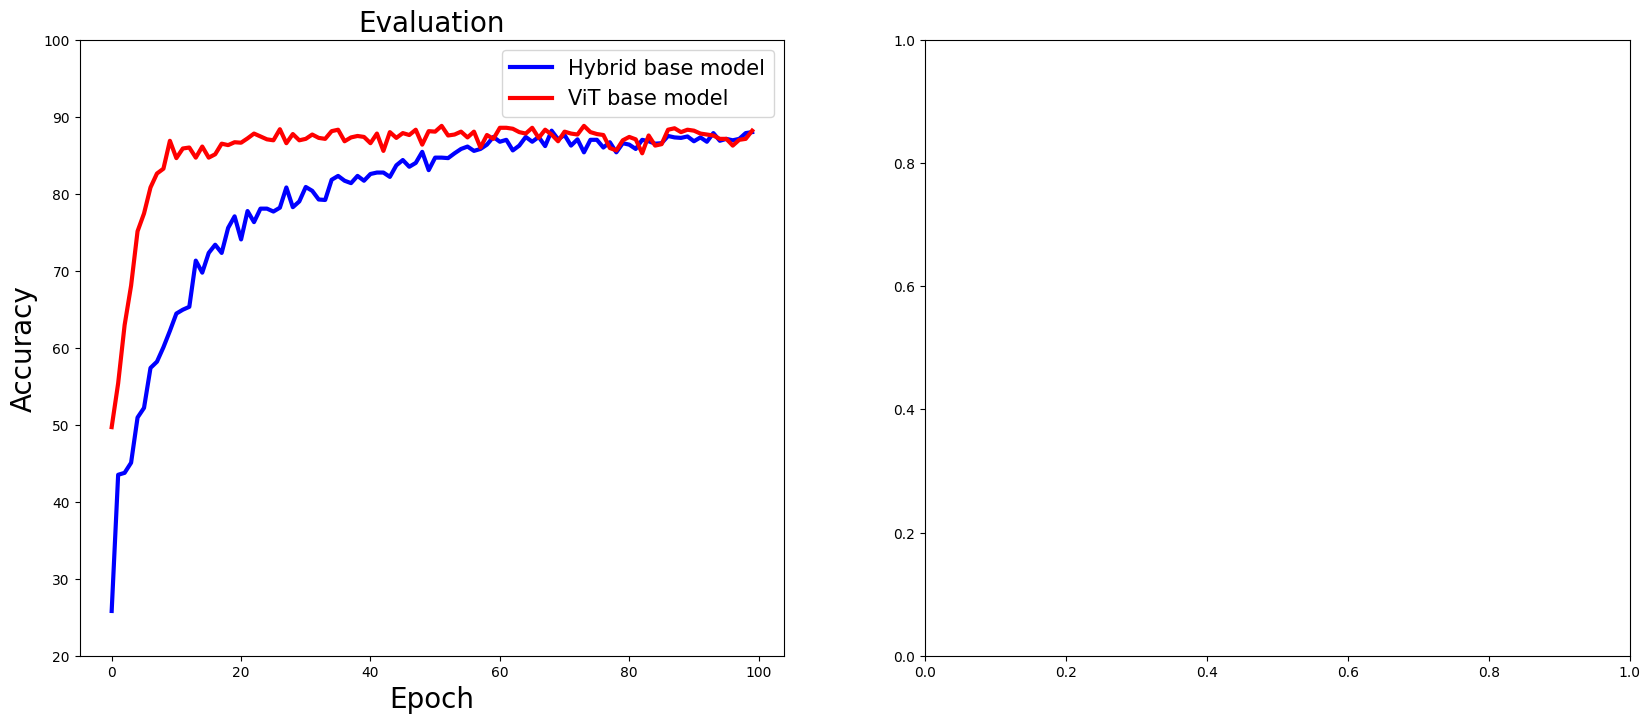

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize = (20,8))

# test accuracy
axes[0].plot(hybrid_avg_results, c = 'b', linestyle = 'solid', linewidth = 3)
axes[0].plot(vit_avg_results, c = 'r', linestyle = 'solid', linewidth = 3)

axes[0].set_ylim(20,100)

axes[0].set_title("Evaluation", fontsize=20)
axes[0].set_xlabel('Epoch', fontsize = 20)
axes[0].set_ylabel('Accuracy', fontsize = 20)

axes[0].legend(['Hybrid base model', 'ViT base model'], fontsize = 15)

# plot
plt.show()